# Data visualisation

In [1]:
import torch
import json
import os

In [2]:
root = '/DATATWO/users/mincut/Object-Centric-VideoAnswering'
datadir='/DATATWO/users/mincut/Object-Centric-VideoAnswering/data/train' 

In [3]:
f=json.load(open(os.path.join(datadir,'train.json')))

In [4]:
categories = dict()
for pt in f:
    key = pt["question_type"]
    if key in categories.keys():
        categories[key] += 1
    else:
        categories[key] = 1
print(categories)

KeyError: 'question_type'

In [5]:
type(f[0])

dict

In [6]:
f[0].keys()

dict_keys(['questions', 'scene_index', 'video_filename'])

In [7]:
f[1]['scene_index']

1

In [8]:
print(f[1]['video_filename'])

video_00001.mp4


In [9]:
for x in ((f[1]['questions'])):
    print(x['question'],x['question_type'])

What is the color of the object that exits the scene? descriptive
What material is the object to collide with the red object? descriptive
What is the material of the object to collide with the cube? descriptive
How many gray spheres exit the scene after the cylinder enters the scene? descriptive
How many rubber objects exit the scene? descriptive
Are there any cylinders that exit the scene before the gray sphere exits the scene? descriptive
What color is the stationary rubber object when the video begins? descriptive
What material is the moving sphere when the video ends? descriptive
How many moving metal objects are there when the video ends? descriptive
How many moving cylinders are there? descriptive
Are there any moving metal objects when the video ends? descriptive
Which of the following is responsible for the gray object's exit? explanatory
Which of the following is not responsible for the purple sphere's colliding with the gray object? explanatory
What will happen next? predicti

In [10]:
%%HTML
<video width="320" height="240" controls>
  <source src="video_00000.mp4" type="video/mp4">
</video>

In [11]:
import os, json 
root='/DATATWO/users/mincut/Object-Centric-VideoAnswering/data'
questions_path = os.path.join(root,"train",f"train.json")
dtst = json.load(open(questions_path))
print(len(dtst),dtst[0]['questions'][0].keys())

10000 dict_keys(['question_id', 'question', 'question_type', 'question_subtype', 'program', 'answer'])


In [12]:
root='/DATATWO/users/mincut/Object-Centric-VideoAnswering/data'
for mode in ['train','validation','test']:
    questions_path = os.path.join(root,mode,f"{mode}.json")
    cat = dict()
    dtst = json.load(open(questions_path))
    for dt_pt in dtst:
        for q in dt_pt['questions']:
            import pdb ; pdb.set_trace()
            cat[q['question_type']] = cat.get(q['question_type'],0)+1
            print(q['question_id'])
    print(cat)

> /tmp/ipykernel_2411040/2163411507.py(9)<module>()
      7         for q in dt_pt['questions']:
      8             import pdb ; pdb.set_trace()
----> 9             cat[q['question_type']] = cat.get(q['question_type'],0)+1
     10             print(q['question_id'])
     11     print(cat)



# Preprocessing, Dataset and DataLoader 

In [ ]:
##def preprocess
import cv2
import os

# Open the video file

def preprocess_video(path):

    cap = cv2.VideoCapture(path)

    # Create a directory to store the extracted frames
    name = path.split('/')[-1]
    name = name.split('.')[0].split('_')[-1]
    mode = path.split('/')[-4]
    
    output_dir = f'extracted_frames/{mode}/{name}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Set the time interval to extract frames (in milliseconds)
    interval = 100

    # Get the frame rate of the video
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Calculate the number of frames to skip
    skip_frames = int(fps * (interval / 1000))

    # Initialize variables
    frame_count = 0
    success = True

    # Loop through the video frames
    while success:
        # Read a frame from the video
        success, frame = cap.read()
        # Check if the frame was read successfully
        if success:
            # Check if the current frame is a multiple of the skip frames
            if frame_count % skip_frames == 0:
                # Save the extracted frame as an image file
                output_path = os.path.join(output_dir, f"frame{frame_count}.jpg")
                cv2.imwrite(output_path, frame)
                

            # Increment the frame count
            frame_count += 1

    # Release the video capture object and close all windows
    cap.release()
    cv2.destroyAllWindows()


In [ ]:
# preprocess_video('data/train/video/video_00000-01000/video_00000.mp4')
import glob
path = 'data/'
videos = [f for f in glob.glob(path + "**/*.mp4", recursive=True)]
for video in videos:
    preprocess_video(video)

## Dataset

In [ ]:
data = '/DATATWO/users/mincut/Object-Centric-VideoAnswering/data'
import os, sys
import json
import torch
from torch.utils.data import Dataset
import cv2

In [ ]:
class VidQA(Dataset):
    
    def __init__(self,mode='train'):
        
        self.dtst_fldr = os.path.join(data,mode)
        self.mode = mode
        self.ques_file = os.path.join(self.dtst_fldr,f"{mode}.json")
        self.ques,self.ques_types,self.ques_vid = self.read_questions()
#         self.frames = self.read_frames()
    
    def read_frames(self,filename):
        folder = os.path.join(root,'extracted_frames',mode)
        idx = filename.split('_')[-1]
        frame_fldr = os.path.join(folder,idx)
        frm_seq = []
        for fl in os.scandir(frame_fldr):
            img = cv2.imread(fl.path)
            # Convert the image from BGR to RGB format
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Convert image to torch tensor
            img = torch.from_numpy(img.transpose((2, 0, 1)))
            frm_seq.append(img)
                        
        return torch.stack(frm_seq)
        
    def read_questions(self):
        mode = self.mode 
        q_path = os.path.join(root,mode,f"{mode}.json")
        cat = dict()
        q_list = []
        qt_list = []
        qt_vid = []
        dtst = json.load(open(q_path))
        for dt_pt in dtst:
            vid_idx = dt_pt['video_filename'].split('.')[0].split('_')[-1]
            vid_idx = int(vid_idx)
            for q in dt_pt['questions']:
                cat[q['question_type']] = cat.get(q['question_type'],0)+1
                q_list.append(q['question'])
                qt_list.append(q['question_id'])
                qt_vid.append(vid_idx)
                
        return q_list,qt_list,qt_vid 
    
    def gen_vocab(self):
        pass 
        
    def tokenize_sentences(self):
        pass 
        
    
    def __len__(self):
        return len(self.ques)
    
    def __getitem__(self,idx):
        
        return frm 
        
    

In [ ]:
trn_dtst = VidQA()

# Segment Anything

In [54]:
import os, sys
import cv2
import matplotlib.pyplot as plt 
import numpy as np 
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
root = '/DATATWO/users/mincut/Object-Centric-VideoAnswering'
datadir='/DATATWO/users/mincut/Object-Centric-VideoAnswering/data' 
ckpt='/DATATWO/users/mincut/segment-anything/sam_vit_h_4b8939.pth'

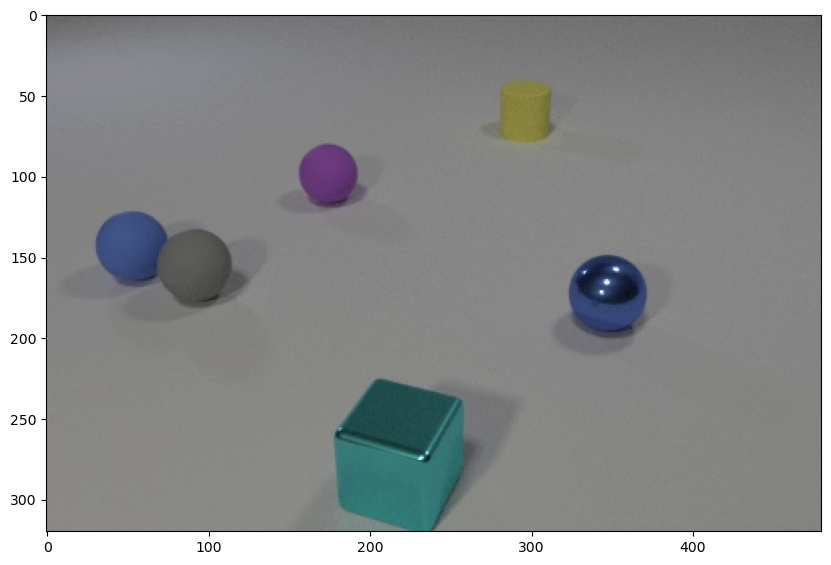

In [55]:
mode = 'train'
frame_folder = os.path.join(datadir,'extracted_frames',mode)

for vid in os.scandir(frame_folder):
    for frm in os.scandir(vid.path):
        path = '/DATATWO/users/mincut/Object-Centric-VideoAnswering/data/extracted_frames/train/00000/frame32.jpg'
        image = cv2.imread(path)
        # image = cv2.imread(frm.path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        plt.axis('on')
        plt.show()
        break
    break

In [56]:
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry["default"](checkpoint=ckpt)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

In [57]:
masks = mask_generator.generate(image)

In [58]:
print(len(masks))

23


In [50]:
print(masks[0].keys())
for mask in masks:
    print(mask['predicted_iou'])


dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
1.0650259256362915
1.0209054946899414
1.0142661333084106
1.0096176862716675
1.006901741027832
1.005698800086975
0.9996570348739624
0.997525691986084
0.9969919323921204
0.9753189086914062
0.9736987948417664
0.9678570032119751
0.9596157073974609
0.9557937383651733
0.9523153901100159
0.9509751200675964
0.9472899436950684
0.9380914568901062
0.9325661659240723
0.9276407361030579
0.9208332896232605
0.9088061451911926
0.8964635133743286


In [59]:
print(mask.keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [39]:
print(mask['bbox'])
print(mask['point_coords'])
print(mask['crop_box'])

[118, 148, 30, 37]
[[127.5, 165.0]]
[0, 0, 480, 320]


In [60]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [61]:
def write_masks_to_folder(masks, path: str) -> None:
    header = "id,area,bbox_x0,bbox_y0,bbox_w,bbox_h,point_input_x,point_input_y,predicted_iou,stability_score,crop_box_x0,crop_box_y0,crop_box_w,crop_box_h"  # noqa
    metadata = [header]
    for i, mask_data in enumerate(masks):
        mask = mask_data["segmentation"]
        print(i,mask_data['area'])
        filename = f"{i}_frame20.png"
        cv2.imwrite(os.path.join(path, filename), mask * 255)
        mask_metadata = [
            str(i),
            str(mask_data["area"]),
            *[str(x) for x in mask_data["bbox"]],
            *[str(x) for x in mask_data["point_coords"][0]],
            str(mask_data["predicted_iou"]),
            str(mask_data["stability_score"]),
            *[str(x) for x in mask_data["crop_box"]],
        ]
        row = ",".join(mask_metadata)
        metadata.append(row)
    metadata_path = os.path.join(path, "metadata.csv")
    with open(metadata_path, "w") as f:
        print(metadata_path)
        f.write("\n".join(metadata))

    return

AttributeError: 'dict' object has no attribute 'shape'

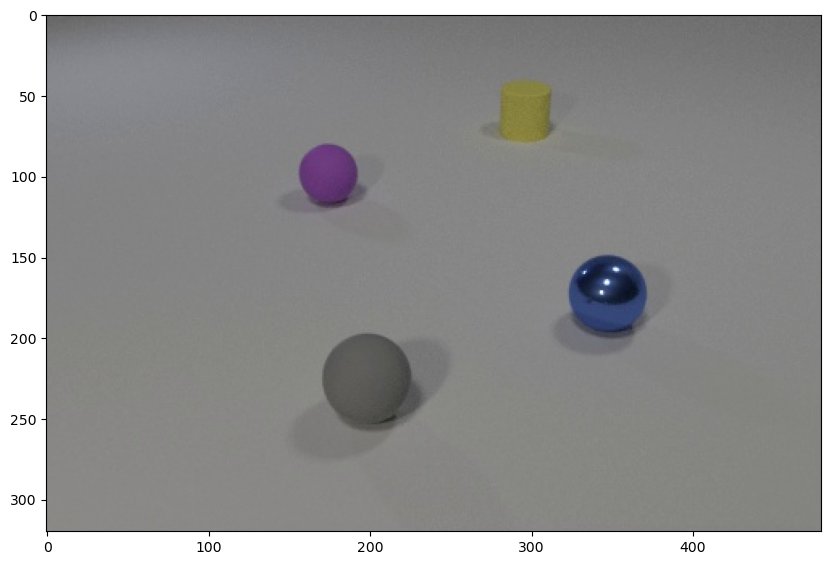

In [15]:
for i, mask in enumerate(masks):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    plt.axis('off')
    plt.show()  

In [62]:
write_masks_to_folder(masks, datadir)

0 138034
1 5879
2 1041
3 1450
4 1614
5 1812
6 3078
7 1106
8 2435
9 788
10 447
11 757
12 276
13 275
14 618
15 822
16 1607
17 431
18 3090
19 861
20 255
21 701
22 428
/DATATWO/users/mincut/Object-Centric-VideoAnswering/data/metadata.csv


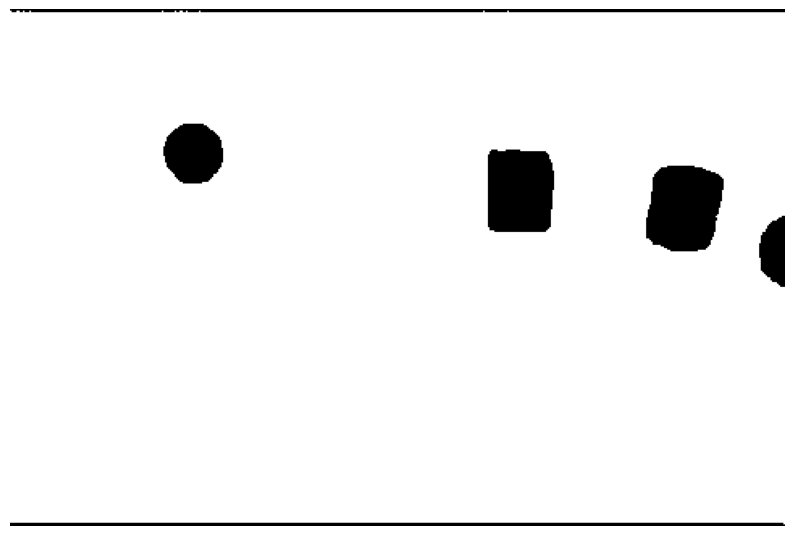

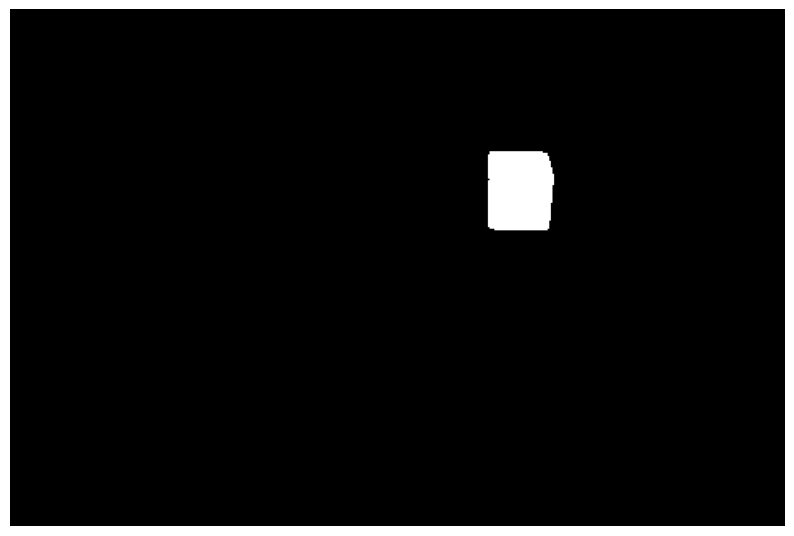

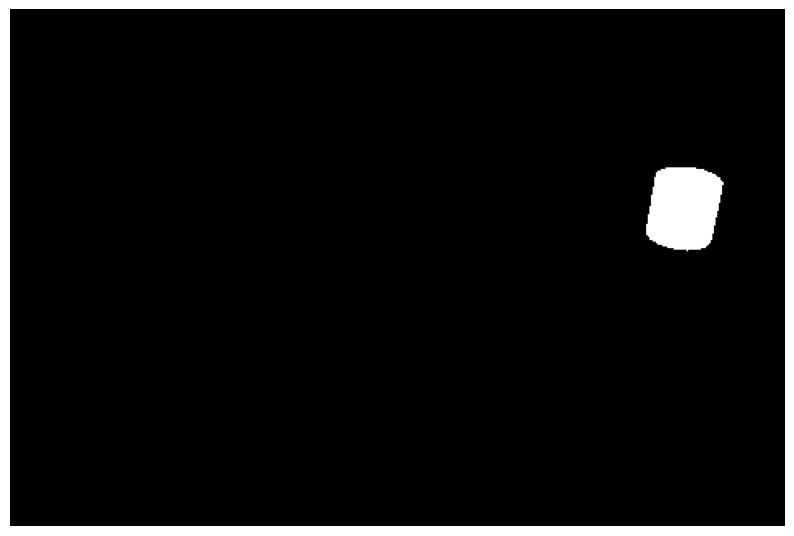

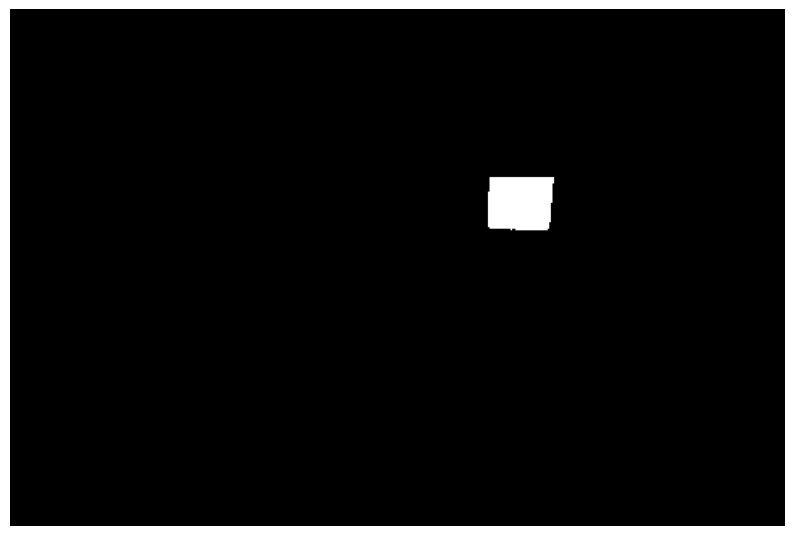

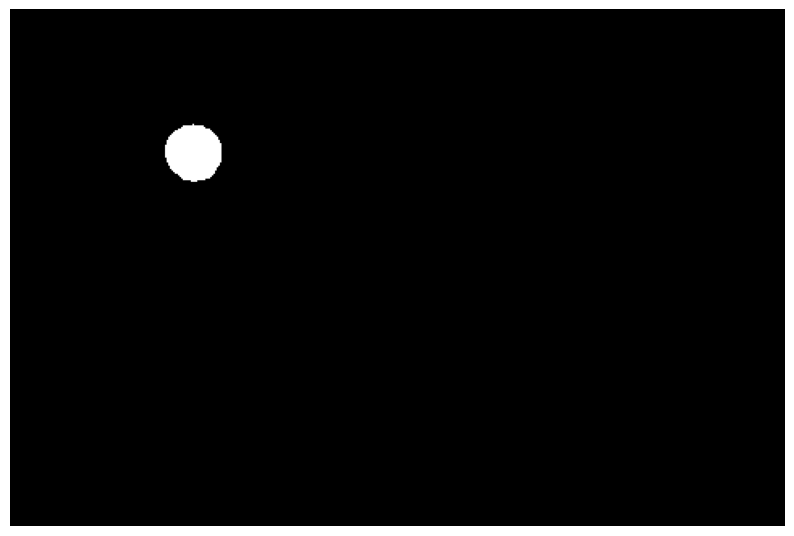

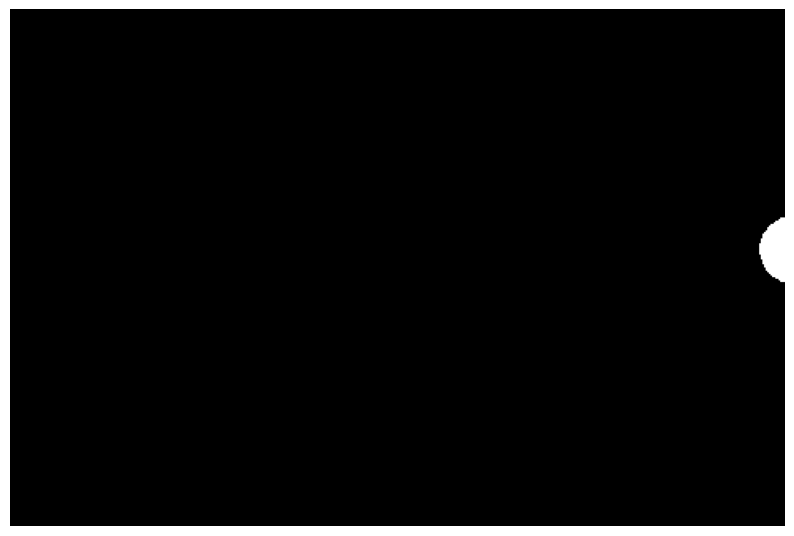

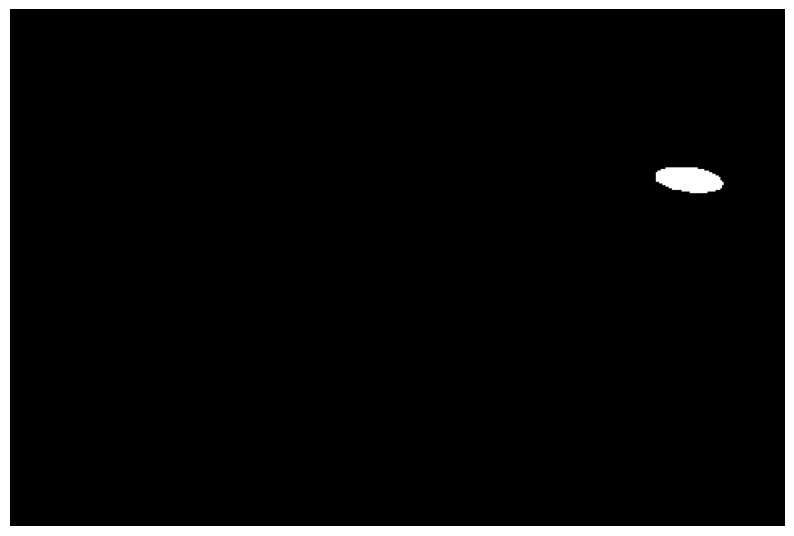

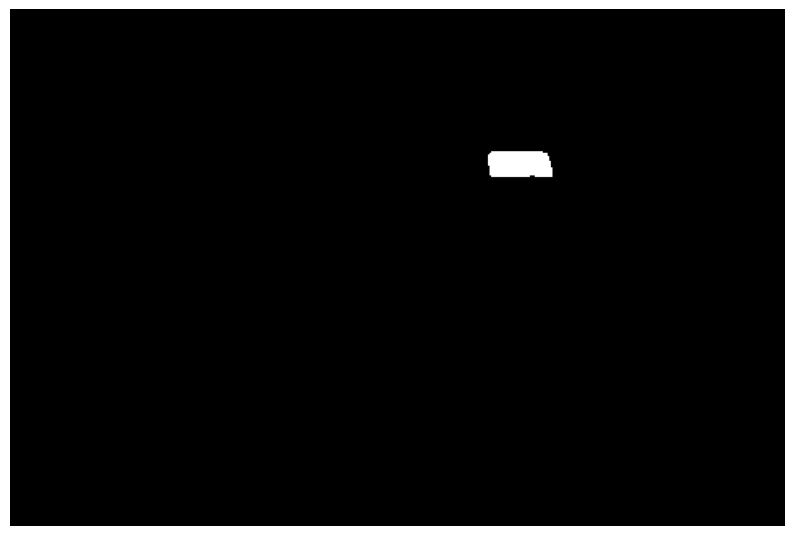

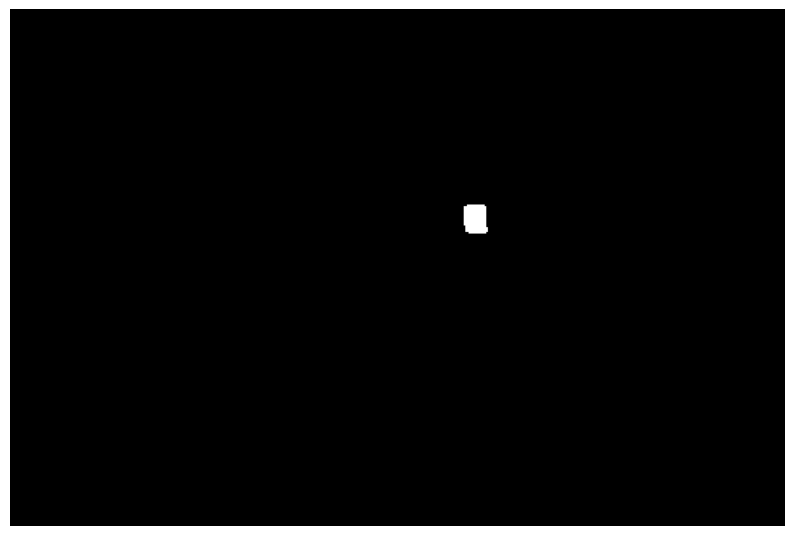

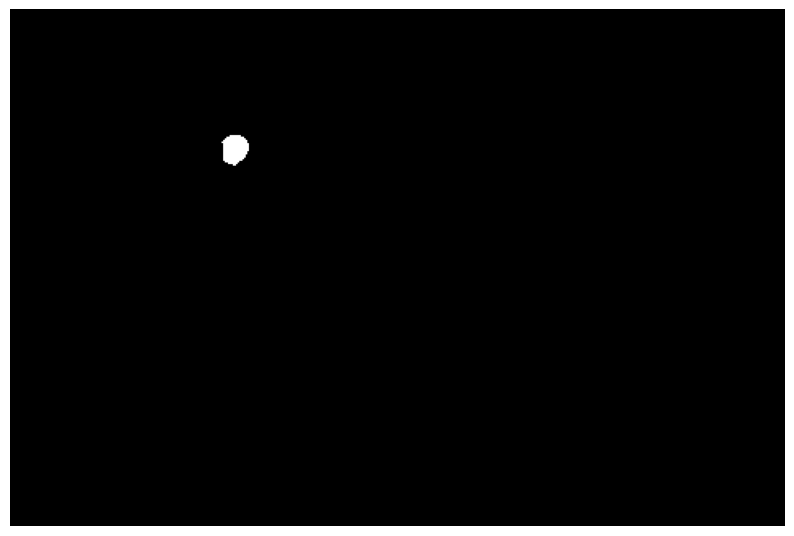

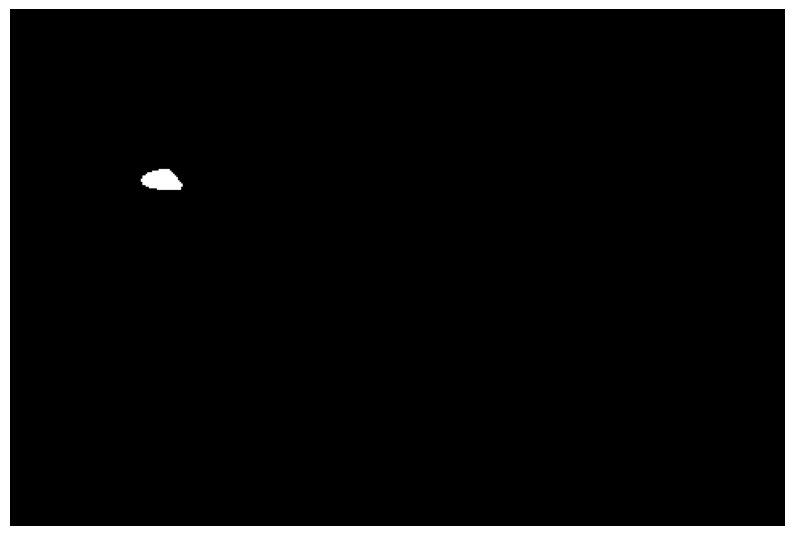

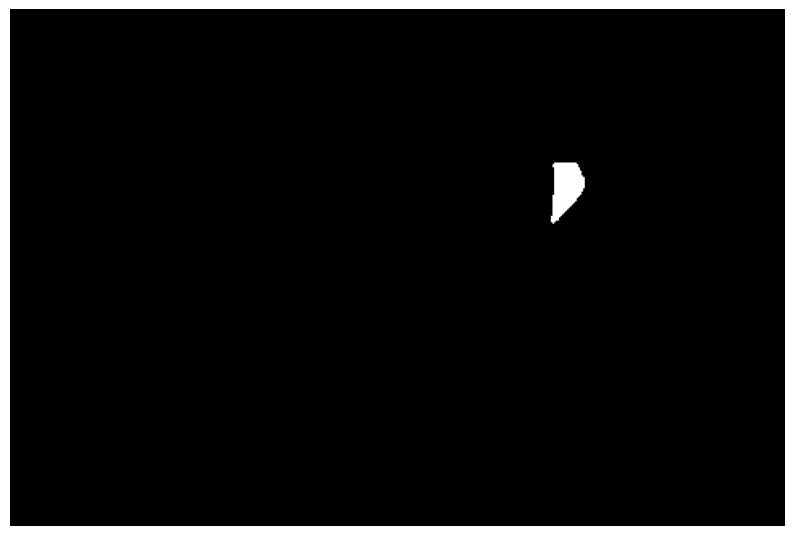

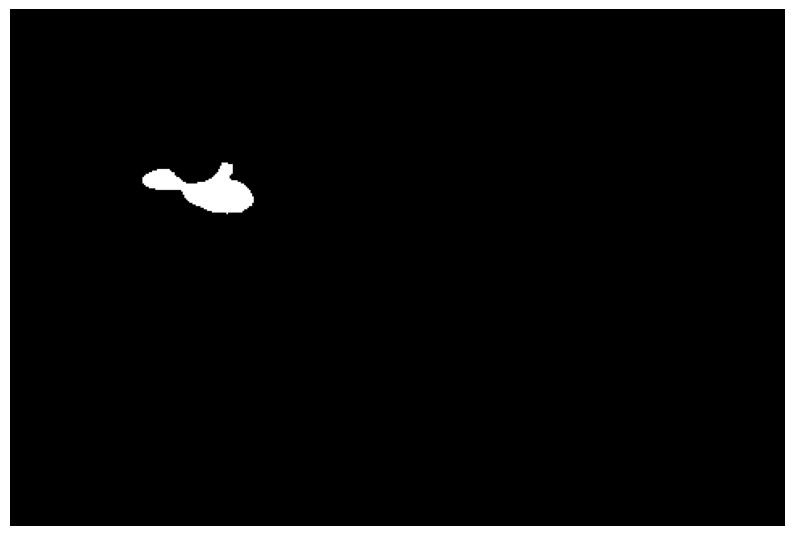

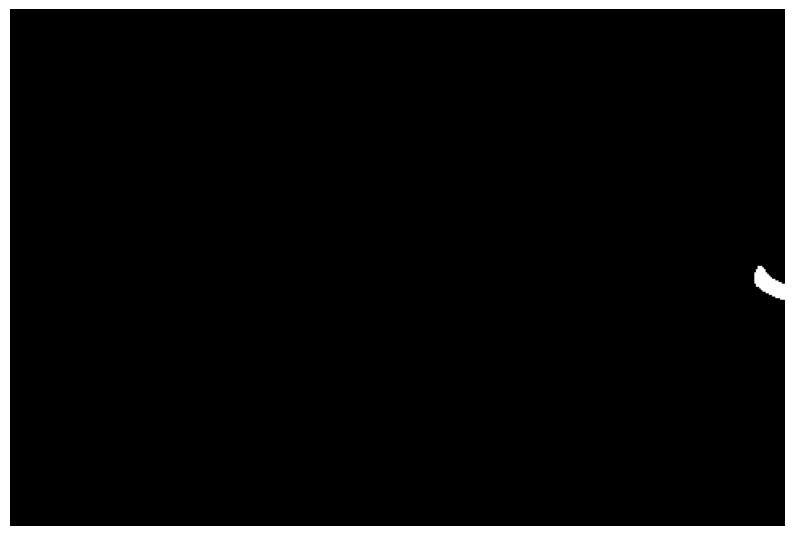

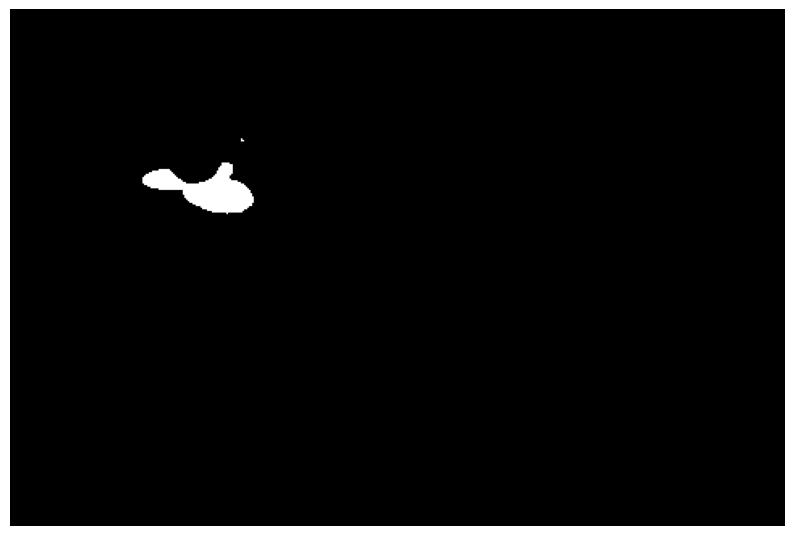

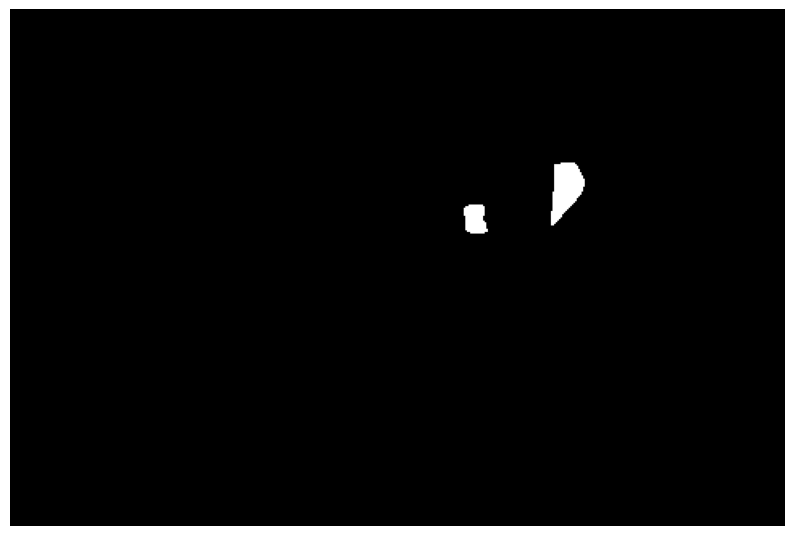

In [42]:
for i in range(16):
    plt.figure(figsize=(10,10))
    image = cv2.imread(os.path.join(datadir,f"{i}.png"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()  

In [8]:
resnet_ft = "/DATATWO/users/mincut/Object-Centric-VideoAnswering/data/features_resnet/train/0.npy"
bbox_ft = "/DATATWO/users/mincut/Object-Centric-VideoAnswering/data/features/train/0.npy"

In [9]:
import os, json 

In [10]:
import numpy as np
x = np.load(bbox_ft)

In [11]:
y = np.load(resnet_ft)

In [13]:
y.shape

(4, 5000)